In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch.utils.data import DataLoader, TensorDataset

Epoch [100/1000], Loss: 18369.3164
Epoch [200/1000], Loss: 0.9188
Epoch [300/1000], Loss: 0.0002
Epoch [400/1000], Loss: 0.0002
Epoch [500/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001


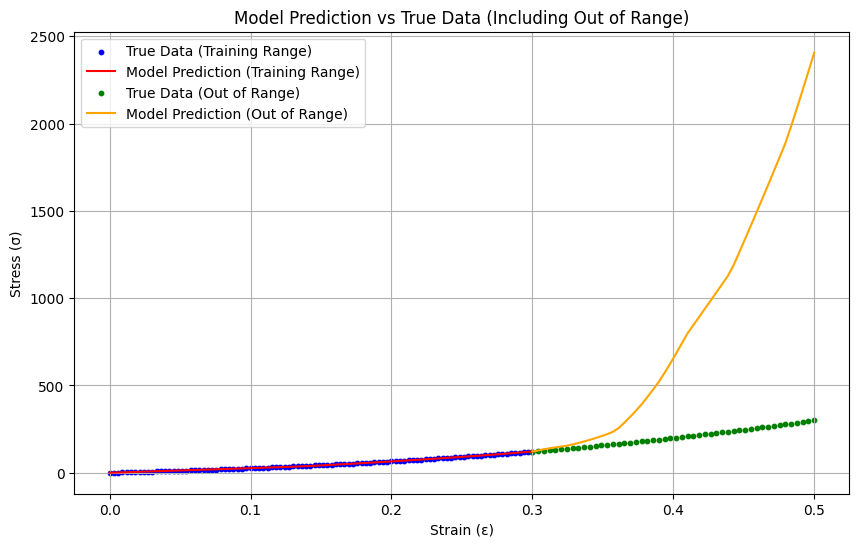

In [2]:

# Code 2: Generate strain-stress data
E_modulus = 200  # Elastic modulus (MPa)
C1, C2 = 500, 600  # Nonlinear coefficients
noise_level = 0  # Set to zero for clean data

def generate_nonlinear_elastic_data(epsilon_values, E, C1, C2, noise_level):
    sigma = E * epsilon_values + C1 * epsilon_values ** 2 + C2 * epsilon_values ** 3
    noise = noise_level * np.random.randn(*epsilon_values.shape)
    return sigma + noise

epsilon_train = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_train = generate_nonlinear_elastic_data(epsilon_train, E_modulus, C1, C2, noise_level).astype(np.float32)

# Convert to PyTorch tensors
epsilon_train_tensor = torch.tensor(epsilon_train, requires_grad=False)
sigma_train_tensor = torch.tensor(sigma_train)

# Code 1: Integrate the strain-stress data into the model training
# Normalize the data using min-max normalization
x_data = epsilon_train_tensor.numpy()
y_data = sigma_train_tensor.numpy()

x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()

x_data = (x_data - x_min) / (x_max - x_min)
y_data = (y_data - y_min) / (y_max - y_min)

x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)

# Create DataLoader for shuffling
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define a Constrained Linear Model
class ConstrainedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ConstrainedLinear, self).__init__()
        self.Q = nn.Parameter(torch.randn(out_features, in_features))
        self.alpha = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        alpha_squared = F.softplus(self.alpha) + 1e-6
        W = (1 / (alpha_squared ** 2)) * torch.log1p(torch.exp(alpha_squared ** 2 * self.Q))
        return F.linear(x, W)

# Define a simple neural network model
class ICNN(nn.Module):
    def __init__(self):
        super(ICNN, self).__init__()
        self.layer1 = nn.Linear(1, 20)
        self.constrained_layer1 = ConstrainedLinear(20, 10)
        self.constrained_layer2 = ConstrainedLinear(10, 10)
        self.constrained_layer3 = ConstrainedLinear(10, 1)
        self.A = nn.Parameter(torch.randn(1, 10))
        self.shortcut_layer2 = nn.Linear(1, 10, bias=False)
        self.shortcut_layer3 = nn.Linear(1, 10, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x):
        shortcut2 = self.shortcut_layer2(x)
        shortcut3 = self.shortcut_layer3(x)
        x = self.activation(self.layer1(x))
        x = self.activation(self.constrained_layer1(x) + shortcut2)
        x = self.activation(self.constrained_layer2(x) + shortcut3)
        quadratic_term = torch.matmul(x, self.A.T)
        quadratic_term = torch.matmul(quadratic_term, self.A)
        quadratic_output = torch.sum(quadratic_term * x, dim=1, keepdim=True)
        x = self.constrained_layer3(x) + quadratic_output
        return x

# Instantiate the model, define loss and optimizer
model = ICNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with gradient clipping
epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
y_pred = model(x_tensor).detach().numpy()

# Unnormalize for plotting
x_data = x_data * (x_max - x_min) + x_min
y_data = y_data * (y_max - y_min) + y_min
y_pred = y_pred * (y_max - y_min) + y_min

# Generate out-of-range strain data for evaluation
epsilon_out_of_range = np.linspace(0.3, 0.5, 50).reshape(-1, 1).astype(np.float32)

# Normalize the out-of-range data using the same normalization parameters as the training data
epsilon_out_of_range_normalized = (epsilon_out_of_range - x_min) / (x_max - x_min)

# Convert to PyTorch tensor
epsilon_out_of_range_tensor = torch.tensor(epsilon_out_of_range_normalized, dtype=torch.float32)

# Predict using the trained model
sigma_out_of_range_pred = model(epsilon_out_of_range_tensor).detach().numpy()

# Unnormalize the predictions
sigma_out_of_range_pred = sigma_out_of_range_pred * (y_max - y_min) + y_min

# Analytical comparison for the out-of-range data
sigma_out_of_range_analytical = (
    E_modulus * epsilon_out_of_range
    + C1 * epsilon_out_of_range ** 2
    + C2 * epsilon_out_of_range ** 3
)

# Plot in-range and out-of-range results
plt.figure(figsize=(10, 6))

# Plot training range predictions
plt.scatter(x_data, y_data, label='True Data (Training Range)', color='blue', s=10)
plt.plot(x_data, y_pred, label='Model Prediction (Training Range)', color='red')

# Plot out-of-range predictions
plt.scatter(epsilon_out_of_range, sigma_out_of_range_analytical, label='True Data (Out of Range)', color='green', s=10)
plt.plot(epsilon_out_of_range, sigma_out_of_range_pred, label='Model Prediction (Out of Range)', color='orange')

plt.legend()
plt.xlabel('Strain (ε)')
plt.ylabel('Stress (σ)')
plt.title('Model Prediction vs True Data (Including Out of Range)')
plt.grid(True)
plt.show()
